In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

In [8]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
scaler = MinMaxScaler()
X = scaler.fit_transform(quant.values)

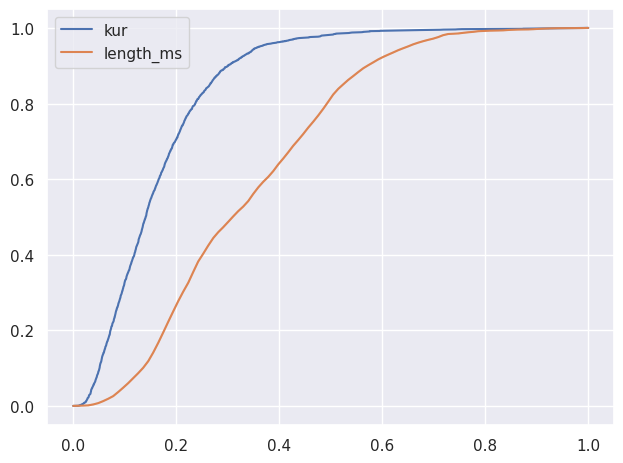

In [22]:
u = np.linspace(0,1, len(quant))
for i,feat in enumerate(quant.columns[:2]):
    g = np.sort(X[:,i])
    sns.lineplot(x=g, y=u, label=f"{feat}")

In [3]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))

clusters = shc.linkage(X, 
            method='ward', 
            metric="euclidean")

<Figure size 1000x700 with 0 Axes>

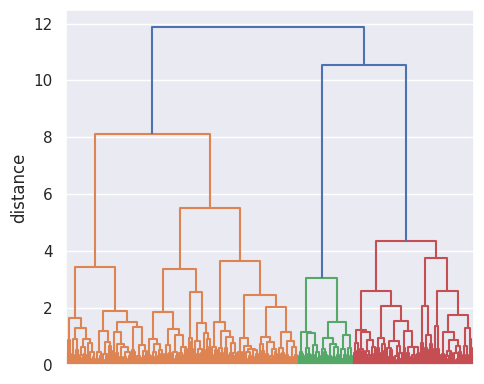

In [4]:
fig, ax = plt.subplots(figsize=(5,4))
shc.dendrogram(Z=clusters);
plt.xticks([])
plt.ylabel("distance")
plt.savefig("hier_DENDR.pdf")

In [5]:
ts = np.linspace(2.5,20, 20)
mi_df =pd.DataFrame(columns =["distance","category", "AMI", "n_clust", "sil"])
for cat in categ.columns:
    for t in ts:
        labels = shc.fcluster(clusters, t, criterion="distance")
        n_clust = len(np.unique(labels))
        amis = {}
        amis["distance"] = [t]
        amis["category"] = [cat]
        amis["AMI"] = [adjusted_mutual_info_score(labels, categ[cat])]
        if n_clust > 1:
            amis["sil"] = [silhouette_score(X, labels)]
        else:
            amis["sil"] = 0
        amis["n_clust"] = [n_clust]

        mi_df = pd.concat([mi_df, pd.DataFrame(amis)], ignore_index=True);

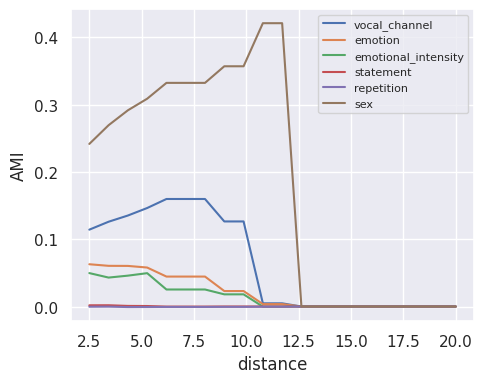

In [6]:
fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=mi_df, x="distance",y="AMI", hue="category")
plt.legend(fontsize=8)
plt.savefig("hier_MI.pdf")

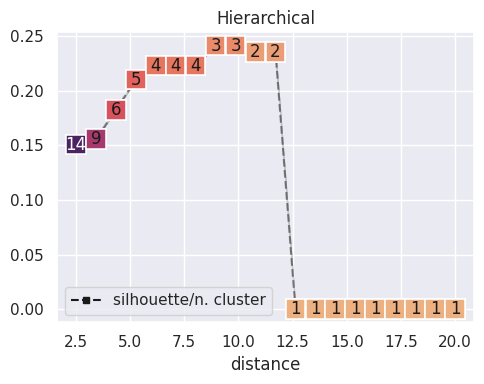

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
from matplotlib.lines import Line2D

# sns.lineplot(data=mi_df, x="Ward distance", y="maxAMI", color="k", alpha=0.5)
# sns.lineplot(data=mi_df, x="Ward distance", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=mi_df, x="distance", y="sil", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=mi_df, x="distance", y="sil", hue="n_clust", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in mi_df[mi_df.category=="sex"].iterrows():
    if record["n_clust"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clust"])), (record["distance"], record["sil"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [#Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    #Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Hierarchical")
plt.ylabel("")
plt.savefig("hier_sil.pdf")

In [8]:
mi_df = pd.DataFrame(columns=["n_clust", "category", "AMI", "sil"])
for n_clust in np.arange(2, 22):
    for cat in categ.columns:

        labels = shc.fcluster(clusters, n_clust, criterion="maxclust")
        amis = {}
        amis["category"] = [cat]
        amis["AMI"] = [adjusted_mutual_info_score(labels, categ[cat])]
        if n_clust > 1:
            amis["sil"] = [silhouette_score(X, labels)]
        else:
            amis["sil"] = 0
        amis["n_clust"] = [n_clust]

        mi_df = pd.concat([mi_df, pd.DataFrame(amis)], ignore_index=True);

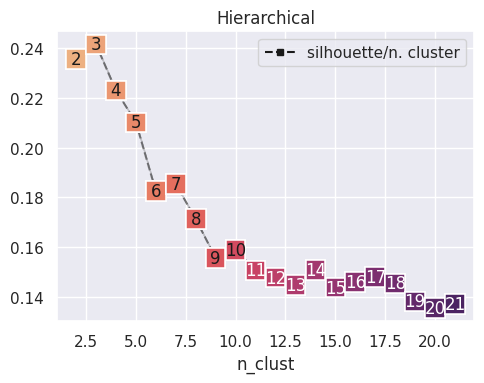

In [9]:
fig, ax = plt.subplots(figsize=(5,4))
from matplotlib.lines import Line2D

# sns.lineplot(data=mi_df, x="Ward distance", y="maxAMI", color="k", alpha=0.5)
# sns.lineplot(data=mi_df, x="Ward distance", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=mi_df, x="n_clust", y="sil", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=mi_df, x="n_clust", y="sil", hue="n_clust", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in mi_df[mi_df.category=="sex"].iterrows():
    if record["n_clust"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clust"])), (record["n_clust"], record["sil"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [#Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    #Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("Hierarchical")
plt.ylabel("")
plt.savefig("hier_sil.pdf")

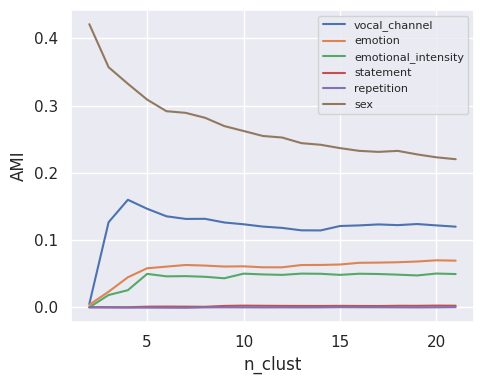

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=mi_df, x="n_clust",y="AMI", hue="category")
plt.legend(fontsize=8)
plt.savefig("hier_MI.pdf")

In [11]:
import umap
reducer = umap.UMAP(n_neighbors=100)
ex, ey = reducer.fit_transform(X).T

In [12]:
edf = pd.DataFrame()
edf["x"] = ex
edf["y"] = ex
edf["label"] = 

SyntaxError: invalid syntax (898347441.py, line 4)